## 深度卷积神经网络（AlexNet）实现图像分类


In [1]:
%matplotlib inline
import torch
import time
import numpy as np
import torchvision

from torch import nn
from matplotlib import pyplot as plt
from torch.utils import data
from torchvision import transforms
from matplotlib_inline import backend_inline

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

## 一、AlexNet简介
![AlexNet论文架构](../img/AlexNet1.png)

2012年，AlexNet横空出世。它首次证明了学习到的特征可以超越手工设计的特征。它一举打破了计算机视觉研究的现状。
AlexNet使用了8层卷积神经网络，并以很大的优势赢得了2012年ImageNet图像识别挑战赛。

AlexNet和LeNet的架构非常相似，如下图所示。 

![从LeNet（左）到AlexNet（右）](../img/alexnet.svg)

AlexNet和LeNet的设计理念非常相似，但也存在显著差异。
首先，AlexNet比相对较小的LeNet5要深得多。
AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。
其次，AlexNet使用ReLU而不是sigmoid作为其激活函数。
### 1. 模型设计

在AlexNet的第一层，卷积窗口的形状是$11\times11$。
由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。
第二层中的卷积窗口形状被缩减为$5\times5$，然后是$3\times3$。
此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为$3\times3$、步幅为2的最大汇聚层。
而且，AlexNet的卷积通道数目是LeNet的10倍。

在最后一个卷积层后有两个全连接层，分别有4096个输出。
这两个巨大的全连接层拥有将近1GB的模型参数。
由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。
幸运的是，现在GPU显存相对充裕，所以我们现在很少需要跨GPU分解模型（因此，现在这个AlexNet模型在这方面与原始论文稍有不同）。

### 2. 激活函数

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。
一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。
另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。
当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。
相反，ReLU激活函数在正区间的梯度总是1。
因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。



#### 2.1 ReLU函数

最受欢迎的激活函数是*修正线性单元*（Rectified linear unit，*ReLU*），
因为它实现简单，同时在各种预测任务中表现良好。
[**ReLU提供了一种非常简单的非线性变换**]。
给定元素$x$，ReLU函数被定义为该元素与$0$的最大值：

(**$$\operatorname{ReLU}(x) = \max(x, 0).$$**)

通俗地说，ReLU函数通过将相应的活性值设为0，仅保留正元素并丢弃所有负元素。
为了直观感受一下，我们可以画出函数的曲线图。
正如从图中所看到，激活函数是分段线性的。


![relu](../img/relu.svg)

当输入为负时，ReLU函数的导数为0，而当输入为正时，ReLU函数的导数为1。
注意，当输入值精确等于0时，ReLU函数不可导。
在此时，我们默认使用左侧的导数，即当输入为0时导数为0。
我们可以忽略这种情况，因为输入可能永远都不会是0。
这里引用一句古老的谚语，“如果微妙的边界条件很重要，我们很可能是在研究数学而非工程”，
这个观点正好适用于这里。
使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。
这使得优化表现得更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题。

#### 2.2 sigmoid函数
[**对于一个定义域在$\mathbb{R}$中的输入，
*sigmoid函数*将输入变换为区间(0, 1)上的输出**]。
因此，sigmoid通常称为*挤压函数*（squashing function）：
它将范围（-inf, inf）中的任意输入压缩到区间（0, 1）中的某个值：

(**$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$**)
曾经sigmoid函数$1/(1 + \exp(-x))$很流行，
因为它类似于阈值函数。
由于早期的人工神经网络受到生物神经网络的启发，
神经元要么完全激活要么完全不激活（就像生物神经元）的想法很有吸引力。
然而，它却是导致梯度消失问题的一个常见的原因，
让我们仔细看看sigmoid函数为什么会导致梯度消失。

![sigmoid](../img/sigmoid.svg)

正如你所看到的，当sigmoid函数的输入很大或是很小时，它的梯度都会消失。
此外，当反向传播通过许多层时，除非我们在刚刚好的地方，
这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失。
当我们的网络有很多层时，除非我们很小心，否则在某一层可能会切断梯度。
事实上，这个问题曾经困扰着深度网络的训练。
因此，更稳定的ReLU系列函数已经成为从业者的默认选择（虽然在神经科学的角度看起来不太合理）。

### 3. 容量控制和预处理

AlexNet通过暂退法控制全连接层的模型复杂度，而LeNet只使用了权重衰减。
为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。
这使得模型更健壮，更大的样本量有效地减少了过拟合。

### 4. AlexNet代码

In [17]:
net = nn.Sequential(
    # 这里，我们使用一个11*11的窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.9),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.9),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

构造一个高度和宽度都为224的(**单通道数据，来观察每一层输出的形状**)。
它与上面的AlexNet架构相匹配。

In [18]:
X = torch.randn(1, 1, 224, 224)
for layer in net: # 获取网络中的每一层
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## 二、读取数据集

尽管论文中AlexNet是在ImageNet上进行训练的，但我在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。
将AlexNet直接应用于Fashion-MNIST的一个问题是，[**Fashion-MNIST图像的分辨率**]（$28 \times 28$像素）(**低于ImageNet图像。**)
为了解决这个问题，(**将它们增加到$224 \times 224$**)（通常来讲这不是一个明智的做法，但我在这里这样做是为了有效使用AlexNet架构）。
使用`load_data_fashion_mnist`函数中的`resize`参数执行此调整。

Fashion-MNIST由10个类别的图像组成， 每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。 因此，训练集和测试集分别包含60000和10000张图像。 测试数据集不会用于训练，只用于评估模型性能。  
每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1。

In [19]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST dataset然后将其加载到内存中去"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。 以下函数用于在数字标签索引及其文本名称之间进行转换。

In [20]:
def get_fashion_mnist_labels(labels):  
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

现在可以创建一个函数来可视化这些样本。

In [21]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

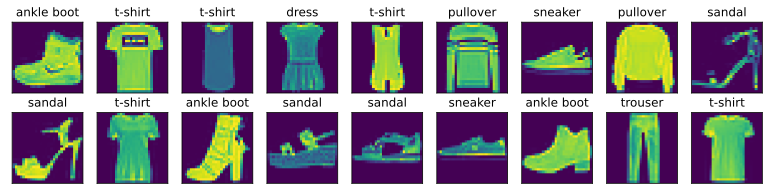

In [23]:
#绘制数据集前十八个图像
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建。 回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。 通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量。

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

## 三、实现辅助函数

In [ ]:
#定义一个累加器
class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
#定义一个计时器
class Timer:  
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的axes"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [ ]:
from IPython import display
class Animator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 四、训练AlexNet

现在，我们可以开始训练AlexNet了。与LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。

### 4.1 分类精度

给定预测概率分布`y_hat`，当我们必须输出硬预测（hard prediction）时，
我们通常选择预测概率最高的类。
许多应用都要求我们做出选择。如Gmail必须将电子邮件分类为“Primary（主要邮件）”、
“Social（社交邮件）”、“Updates（更新邮件）”或“Forums（论坛邮件）”。
Gmail做分类时可能在内部估计概率，但最终它必须在类中选择一个。

当预测与标签分类`y`一致时，即是正确的。
分类精度即正确预测数量与总预测数量之比。
虽然直接优化精度可能很困难（因为精度的计算不可导），
但精度通常是我们最关心的性能衡量标准，我们在训练分类器时几乎总会关注它。

为了计算精度，我们执行以下操作。
首先，如果`y_hat`是矩阵，那么假定第二个维度存储每个类的预测分数。
我们使用`argmax`获得每行中最大元素的索引来获得预测类别。
然后我们[**将预测类别与真实`y`元素进行比较**]。
由于等式运算符“`==`”对数据类型很敏感，
因此我们将`y_hat`的数据类型转换为与`y`的数据类型一致。
结果是一个包含0（错）和1（对）的张量。
最后，我们求和会得到正确预测的数量。

In [ ]:
def accuracy(y_hat, y):  
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [30]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    #GPU训练
    net.to(device)
    #定义优化方式
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    #定义损失函数
    loss = nn.CrossEntropyLoss()
    #画图
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [31]:
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

loss 0.071, train acc 0.975, test acc 0.925
909.5 examples/sec on cuda:0


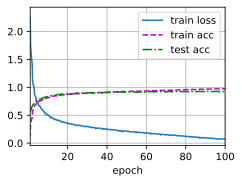

In [34]:
lr, num_epochs = 0.01, 100
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [ ]:
lr, num_epochs = 0.01, 100
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())

## 五、预测结果

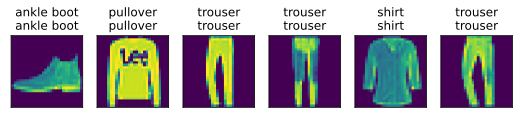

In [33]:
def predict(device, net, test_iter, n=6):
    """显示预测结果"""
    for X, y in test_iter:
        break
    X, y = X.to(device), y.to(device)
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    _, test = load_data_fashion_mnist(batch_size)
    for Y, _ in test:
        break
    show_images(
        Y[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict(try_gpu(), net, test_iter)

## 小结

* AlexNet的架构与LeNet相似，但使用了更多的卷积层和更多的参数来拟合大规模的ImageNet数据集。
* 今天，AlexNet已经被更有效的架构所超越，但它是从浅层网络到深层网络的关键一步。
* 尽管AlexNet的代码只比LeNet多出几行，但学术界花了很多年才接受深度学习这一概念，并应用其出色的实验结果。这也是由于缺乏有效的计算工具。
* Dropout、ReLU和预处理是提升计算机视觉任务性能的其他关键步骤。